In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
# !pip install sentencepiece
!pip install bertopic

In [4]:
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
import os
import json

In [5]:
import os
import json
import re
from zipfile import ZipFile

cond = re.compile('[가-힣]+')

def get_data_from_zip(zip_name):
    zip_file_path = '/content/drive/MyDrive/jolnon/' + zip_name + '.zip'
    extract_path = '/content/' + zip_name

    with ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    result = []
    for name in os.listdir(path=extract_path):
        file_path = os.path.join(extract_path, name)
        if os.path.isdir(file_path):
            for name in os.listdir(path=file_path):
                with open(file_path + '/' + name, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                    valid = []
                    for d in data['content'].split('\n'):
                        res = []
                        for word in d.split(' '):
                            if cond.match(word) != None:
                                res.append(word)
                        d = ' '.join(res)
                        if d and not d.replace(' ', '').isdecimal():
                            valid.append(d)
                    result.append('\n'.join([data['title']] + valid))
        else:
            with open(extract_path + '/' + name, 'r', encoding='utf-8') as f:
                data = json.load(f)
                valid = []
                for d in data['content'].split('\n'):
                    res = []
                    for word in d.split(' '):
                        if cond.match(word) != None:
                            res.append(word)
                    d = ' '.join(res)
                    if d and not d.replace(' ', '').isdecimal():
                        valid.append(d)
                result.append('\n'.join([data['title']] + valid))
    return result


In [41]:
import random
random.seed(42)
galleries = ['tree','drink']
dataset = []
for e in galleries:
  dataset.append([get_data_from_zip(e)])
cocktail = []
for data in dataset:
  for sen in data:
    cocktail+=sen

In [42]:
def remove_words(sentence, word):
    return ' '.join([w.replace(word, '') for w in sentence.split()])
stopwords = ['-dc', 'official', 'App', '이미지' ,'순서','저장','.jpg','.png','.txt','.gif']
for i in range(len(cocktail)):
  for j in range(len(stopwords)):
    cocktail[i] = remove_words(cocktail[i],stopwords[j])

In [43]:
import collections

def remove_top_n_words(data, n):
    words = [word for sentence in data for word in sentence.split(' ')]
    word_count = collections.Counter(words)
    top_n_words = [word for word, _ in word_count.most_common(n)]
    for i in range(len(data)):
        for word in top_n_words:
            if word=='':
                continue
            data[i] = remove_words(data[i], word)
    return data

def remove_empty_sentences(cocktail, real_labels):
  indices = [i for i, sentence in enumerate(cocktail) if sentence.strip() != '']
  cocktail = [cocktail[i] for i in indices]
  real_labels = [real_labels[i] for i in indices]
  return cocktail, real_labels


In [44]:
real_labels = []
for i in range(len(dataset)):
  real_labels += [i] * len(dataset[i][0])
cocktail = remove_top_n_words(cocktail, 0)
cocktail, real_labels = remove_empty_sentences(cocktail, real_labels)

In [ ]:
# !pip install transformers
# from transformers import AutoModel, AutoTokenizer
# model = AutoModel.from_pretrained("klue/roberta-large")
# tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")

# model = AutoModel.from_pretrained("klue/bert-base")
# tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
# bertopic_model_embed_token = BERTopic(embedding_model=model,
#                                       vectorizer_model=vectorizer,
#                                       ctfidf_model=ctfidf_model,
#                                       nr_topics=100,
#                                       top_n_words=1,
#                                       calculate_probabilities=False)

In [46]:
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer(reduce_frequent_words=True)
bertopic_model_embed_token = BERTopic(language='multilingual',
                          nr_topics=100,
                          top_n_words=1)
topics, _ = bertopic_model_embed_token.fit_transform(cocktail)

In [47]:
topic_info = bertopic_model_embed_token.get_topic_info()
number_of_topics = len(topic_info) - 1
print(f"생성된 주제의 수: {number_of_topics}")
lst = []
for index, row in topic_info.iterrows():
    topic_num = row['Topic']
    if topic_num != -1:
        topic_name = row['Name']
        pure_topic_name = "_".join(topic_name.split("_")[1:])
        lst.append(pure_topic_name)

생성된 주제의 수: 99


In [48]:
### Reducing outliers
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="c-tf-idf", threshold=0.1)
topics = bertopic_model_embed_token.reduce_outliers(cocktail, topics, strategy="distributions")

In [49]:
hierarchical_topics = bertopic_model_embed_token.hierarchical_topics(cocktail)

100%|██████████| 98/98 [00:01<00:00, 82.46it/s]


In [61]:
# bertopic_model_embed_token.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [52]:
verify = True
table = [[0 for r in range(2)] for t in range(max([int(x) for x in hierarchical_topics['Parent_ID']]) + 1)]
if verify:
  for j in range(number_of_topics):
    for i in range(len(topics)):
      if topics[i]==j:
        table[j][real_labels[i]]+=1
  for j in range(number_of_topics, len(table)):
    row = hierarchical_topics[hierarchical_topics['Parent_ID'] == str(j)].iloc[0]
    left, right = int(row['Child_Left_ID']), int(row['Child_Right_ID'])
    for i in range(len(table[0])):
      table[j][i] += table[left][i] + table[right][i]

In [53]:
df = hierarchical_topics
selected_topics_ids = set()
for index, row in df[df['Distance'] >= 1].iterrows():
    left_child = df[df['Parent_ID'] == row['Child_Left_ID']]
    if not left_child.empty and left_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Left_ID'])

    right_child = df[df['Parent_ID'] == row['Child_Right_ID']]
    if not right_child.empty and right_child.iloc[0]['Distance'] < 1:
        selected_topics_ids.add(row['Child_Right_ID'])
selected_topics_ids = list(selected_topics_ids)

In [54]:
post_counts = [0 for i in range(number_of_topics)]
for i in range(len(post_counts)):
    post_counts[i] = topics.count(i)

In [55]:
selected_topic_names=[]
for topic_id in selected_topics_ids:
    topic_name = df[df['Parent_ID'] == topic_id]['Parent_Name'].iloc[0]
    selected_topic_names.append(topic_name)

In [56]:
for i in range(len(selected_topic_names)):
  print(selected_topic_names[i], selected_topics_ids[i])

받고 129
추천 149
얼음 108
분갈이 167
냄새가 135
나무 127
토마토 165
위스키 116
벌레 150
신엽 160
식물 142
맛있음 155
꽃이 138
vs 121
이름이 100
잎이 115
버섯 146
자야지 152
잭다니엘 164
일본 159
보관 166
딸기 161
사진 168
커피 151
내일 153
와인 113


In [62]:
ord = [2,2,2,0,2, 0,0,1,0,0, 0,1,0,2,2, 0,0,2,1,2, 2,0,2,1,2,1] #tree drink none

In [63]:
# hierarchical_topics

In [64]:
import numpy as np
import warnings
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

def clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts, ord):
  selected_topic_counts = [[0, 0] for _ in range(len(selected_topics_ids))]
  for i in range(len(selected_topics_ids)):
    selected_topic_counts[i][0] += table[int(selected_topics_ids[i])][0]
    selected_topic_counts[i][1] += table[int(selected_topics_ids[i])][1]
  dic = dict()
  n_clusters = len(galleries) + 1
  idx2name = dict(zip(selected_topics_ids,selected_topic_names))
  name2idx = dict(zip(selected_topic_names,selected_topics_ids))
  clustered_topics_name=[[],[],[]]
  for i in range(len(ord)):
    clustered_topics_name[ord[i]].append(selected_topic_names[i])

  clustered_topics_count = [[] for _ in range(n_clusters)]
  clustered_topics = [[] for _ in range(n_clusters)]
  for i in range(len(clustered_topics_name)):
    for ele in clustered_topics_name[i]:
      clustered_topics[i].append(name2idx[ele])
  for r in clustered_topics_name:
    print(r)
  cluster_sums = []
  for idx, cluster in enumerate(clustered_topics):
    total_sum = 0
    for parent_id in cluster:
      row = hierarchical_topics[hierarchical_topics['Parent_ID'] == parent_id].iloc[0]
      topic_ids = row['Topics']
      cluster_sum = sum(post_counts[topic_id] for topic_id in topic_ids)
      clustered_topics_count[idx].append(cluster_sum)
      total_sum += cluster_sum
    cluster_sums.append(total_sum)
  if verify:
    clustered_count = [[0, 0] for _ in range(n_clusters)]
    for i in range(n_clusters):
      for j in clustered_topics[i]:
        clustered_count[i][0] += table[int(j)][0]
        clustered_count[i][1] += table[int(j)][1]

    for i in range(n_clusters):
      l, r = clustered_count[i][0], clustered_count[i][1]
      for j in range(len(clustered_topics[i])):
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
    clusters = []

    for i in range(n_clusters):
      cluster_info = {}
      l, r = clustered_count[i][0], clustered_count[i][1]
      cluster_info['name'] = f'Cluster #{i+1}'
      cluster_info['value'] = l + r
      cluster_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]

      topics_list = []
      for j in range(len(clustered_topics[i])):
        topic_info = {}
        k = clustered_topics[i][j]
        l, r = table[int(k)][0], table[int(k)][1]
        topic_info['name'] = clustered_topics_name[i][j]
        topic_info['value'] = l + r
        topic_info['distribution'] = [100 * l / (l + r), 100 * r / (l + r)]
        topics_list.append(topic_info)

      cluster_info['topics'] = topics_list
      clusters.append(cluster_info)

    font_path = '/content/drive/MyDrive/NanumSquareRoundR.ttf'
    fontprop = fm.FontProperties(fname=font_path, size=10)
    plt.rcParams["font.family"] = fontprop.get_name()
    plt.rcParams['axes.unicode_minus'] = False

    def sort_topics_by_distribution(cluster):
      cluster['topics'] = sorted(cluster['topics'], key=lambda x: x['distribution'][0], reverse=True)

    for cluster in clusters:
      print(cluster)
      sort_topics_by_distribution(cluster)

    fig, ax = plt.subplots(figsize=(10, 6))

    y_positions = []
    y_labels = []

    current_y = 0
    bar_width = 0.4

    for cluster in clusters:
      y_positions.append(current_y)
      y_labels.append(cluster['name'])
      for topic in cluster['topics']:
        current_y -= 1
        y_positions.append(current_y)
        y_labels.append(topic['name'])
        ax.barh(current_y, topic['distribution'][0], color='r', height=bar_width, label=topic['name'])
        ax.barh(current_y, topic['distribution'][1], color='g', left=topic['distribution'][0], height=bar_width)
      current_y -= 2

    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels, fontproperties=fontprop)
    ax.set_xlabel('커뮤니티 분포', fontproperties=fontprop)
    plt.title("FastText 이용 클러스터링 결과", fontproperties=fontprop)
    plt.ylabel("토픽 이름", fontproperties=fontprop)

    plt.tight_layout()
    plt.show()

    return clustered_topics


['분갈이', '나무', '토마토', '벌레', '신엽', '식물', '꽃이', '잎이', '버섯', '딸기']
['위스키', '맛있음', '잭다니엘', '커피', '와인']
['받고', '추천', '얼음', '냄새가', 'vs', '이름이', '자야지', '일본', '보관', '사진', '내일']
{'name': 'Cluster #1', 'value': 8601, 'distribution': [85.39704685501685, 14.602953144983141], 'topics': [{'name': '분갈이', 'value': 819, 'distribution': [83.76068376068376, 16.23931623931624]}, {'name': '나무', 'value': 212, 'distribution': [86.79245283018868, 13.20754716981132]}, {'name': '토마토', 'value': 705, 'distribution': [81.70212765957447, 18.29787234042553]}, {'name': '벌레', 'value': 409, 'distribution': [91.44254278728606, 8.557457212713937]}, {'name': '신엽', 'value': 170, 'distribution': [75.88235294117646, 24.11764705882353]}, {'name': '식물', 'value': 883, 'distribution': [88.10872027180068, 11.89127972819932]}, {'name': '꽃이', 'value': 686, 'distribution': [94.75218658892128, 5.247813411078718]}, {'name': '잎이', 'value': 4400, 'distribution': [86.20454545454545, 13.795454545454545]}, {'name': '버섯', 'value': 125, 'dist

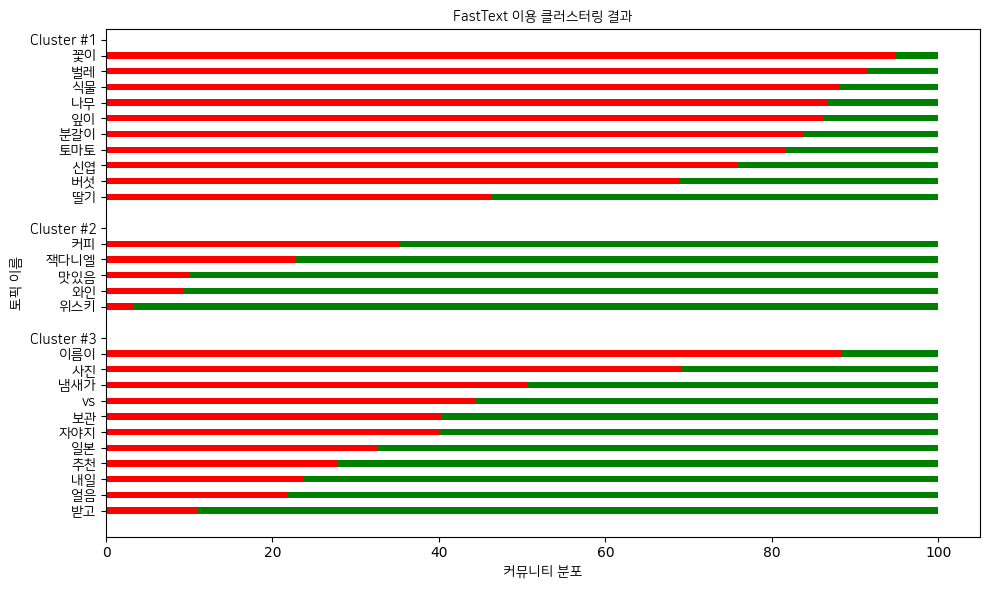

In [65]:
clustered_topics_ids = clusterByHand(table, selected_topics_ids, selected_topic_names, galleries, post_counts, ord)
ratios = [[] for i in range(3)]
for i in range(3):
  ratio = []

  topics_list = []
  for j in range(len(clustered_topics_ids[i])):
    k = clustered_topics_ids[i][j]
    l, r = table[int(k)][0], table[int(k)][1]
    ratio.append(l / (l + r))
  ratios[i] = ratio

[0.8376068376068376, 0.8679245283018868, 0.8170212765957446, 0.9144254278728606, 0.7588235294117647, 0.8810872027180068, 0.9475218658892128, 0.8620454545454546, 0.688, 0.4635416666666667] [0.033, 0.1013215859030837, 0.22815533980582525, 0.35374149659863946, 0.09275834011391375] [0.11010009099181074, 0.2785714285714286, 0.21710526315789475, 0.5070422535211268, 0.4433497536945813, 0.8842592592592593, 0.4, 0.3254663113818043, 0.4034582132564842, 0.6923076923076923, 0.2371967654986523]


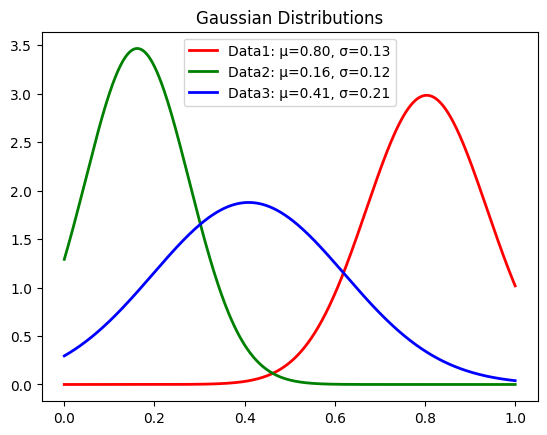

In [70]:
from scipy.stats import norm

def plot_gaussian(data1, data2, data3):
    print(data1, data2, data3)
    # 각 데이터셋에 대한 평균과 표준편차를 계산
    mu1, std1 = np.mean(data1), np.std(data1)
    mu2, std2 = np.mean(data2), np.std(data2)
    mu3, std3 = np.mean(data3), np.std(data3)

    # 모든 데이터의 범위를 기반으로 x 값들을 샘플링
    xmin = min(min(data1), min(data2), min(data3))
    xmax = max(max(data1), max(data2), max(data3))
    x = np.linspace(0, 1, 1000)

    # 확률 밀도 함수 값을 계산
    p1 = norm.pdf(x, mu1, std1)
    p2 = norm.pdf(x, mu2, std2)
    p3 = norm.pdf(x, mu3, std3)

    # 그래프 그리기
    plt.plot(x, p1, 'r', linewidth=2, label=f"Data1: µ={mu1:.2f}, σ={std1:.2f}")
    plt.plot(x, p2, 'g', linewidth=2, label=f"Data2: µ={mu2:.2f}, σ={std2:.2f}")
    plt.plot(x, p3, 'b', linewidth=2, label=f"Data3: µ={mu3:.2f}, σ={std3:.2f}")


    plt.title("Gaussian Distributions")
    plt.legend()
    plt.show()

plot_gaussian(*ratios)